## Corporate Forecasting using Shallow and Generative Learning Models
### This script is concerned with analyzing a dataset from the CRM department and figuring out if there are any margins on being able to predict customer churn rate

In [63]:
import mysql.connector
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm


### **1. Data Understanding**
A deep understanding of the customer churn dataset helped in 
uncovering some key features, namely tenure, complaints, call failures, and churn status. 

The dataset of this use case is a real-world dataset related to customer information from an **Iranian telecommunication company** over a period of 12 months obtained from the *UCI Machine Learning Repository (2020)*.
Dataset has 13 columns with **3150 rows**. Aggregation is performed on the first nine months, and churn labels specify the status for the end of the 12-month period, which has created a three-month planning gap.


In [50]:
# Visualizzazione dei primi record per confermare
print(data.head())

# Informazioni sul DataFrame
print("\nInformazioni sul DataFrame:")
print(data.info())

   Call_Failure  Complains  Subscription_Length  Charge_Amount  \
0             8          0                   38              0   
1             0          0                   39              0   
2            10          0                   37              0   
3            10          0                   38              0   
4             3          0                   38              0   

   Seconds_of_Use  Frequency_of_use  Frequency_of_SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct_Called_Numbers  Age_Group  Tariff_Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3            1       1 

### **2. Data Preparation**
**Data Cleaning:** This involved cleaning the data to deal with discrepancies such as missing values and wrong data types so that the dataset was prepared for analysis.

**Feature Engineering:** The extracted important features had to be converted, if necessary, so that the model developed could generate logical and meaningful insights. For example, numerical data such as tenure and call failures have been normalized to make them modeling consistent.


In [51]:

# Conversione delle colonne a variabili categoriche rimuovendo anche la parte decimale
categorical_columns = ['Age_Group', 'Tariff_Plan', 'Status', 'Churn']

for col in categorical_columns:
    data[col] = data[col].astype(float).astype(int).astype('category')
    
# 1. Pulizia dei Dati
# Rimozione dei duplicati
data = data.drop_duplicates()

# Separazione delle caratteristiche (X) e del target (y)
X = data.drop('Churn', axis=1)
y = data['Churn'].astype('category')

# Identificazione delle colonne numeriche e categoriche
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['category', 'object']).columns

# Creazione di pipeline per la gestione dei dati numerici e categorici
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Composizione delle trasformazioni in un pre-processore
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

# Applicazione del pre-processore ai dati di training
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Applicazione del pre-processore ai dati di testing
X_test_preprocessed = preprocessor.transform(X_test)

# Conversione in DataFrame per la visualizzazione
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessor.get_feature_names_out())
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessor.get_feature_names_out())


### **3. Explorative Data Analysis**

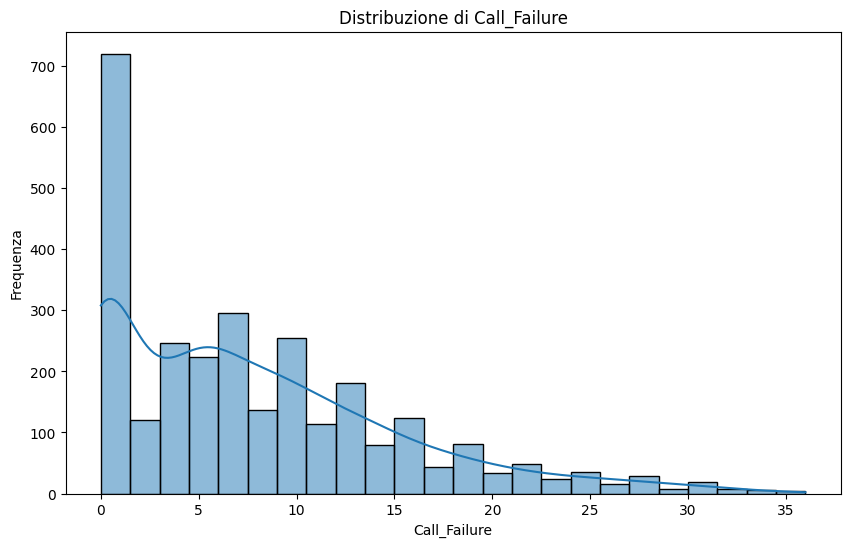

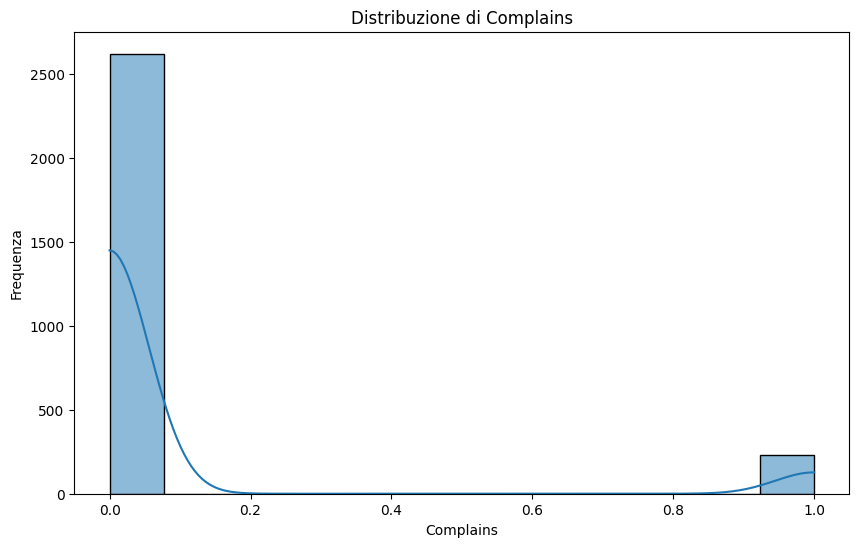

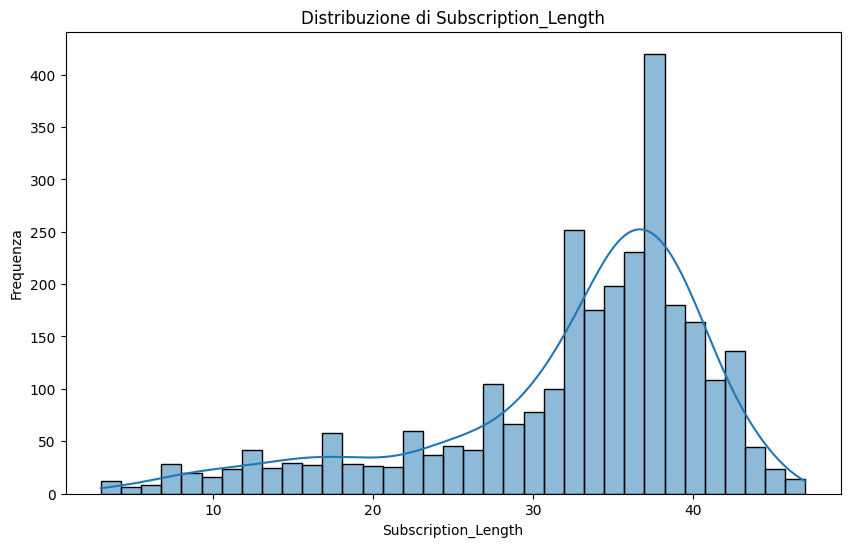

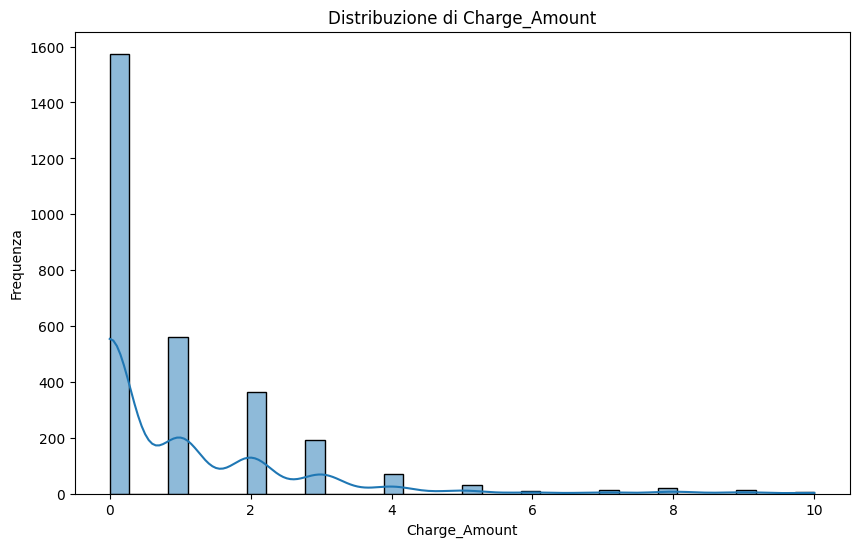

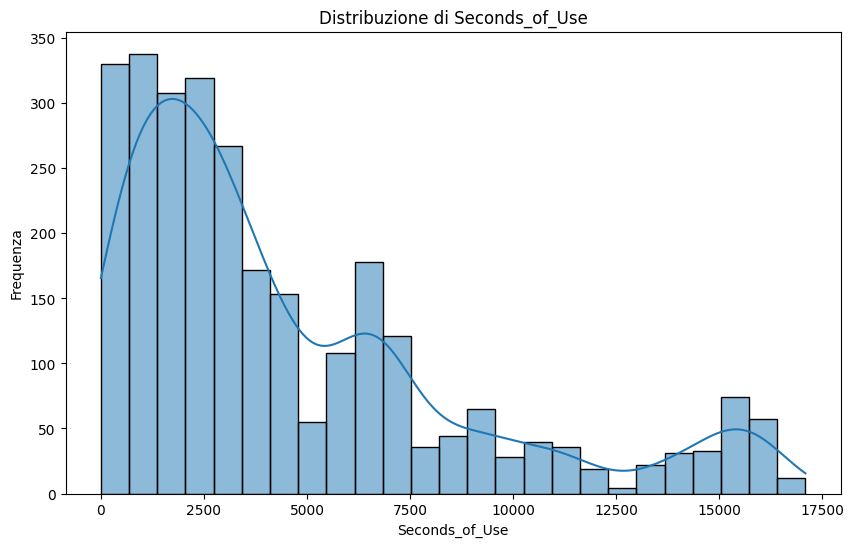

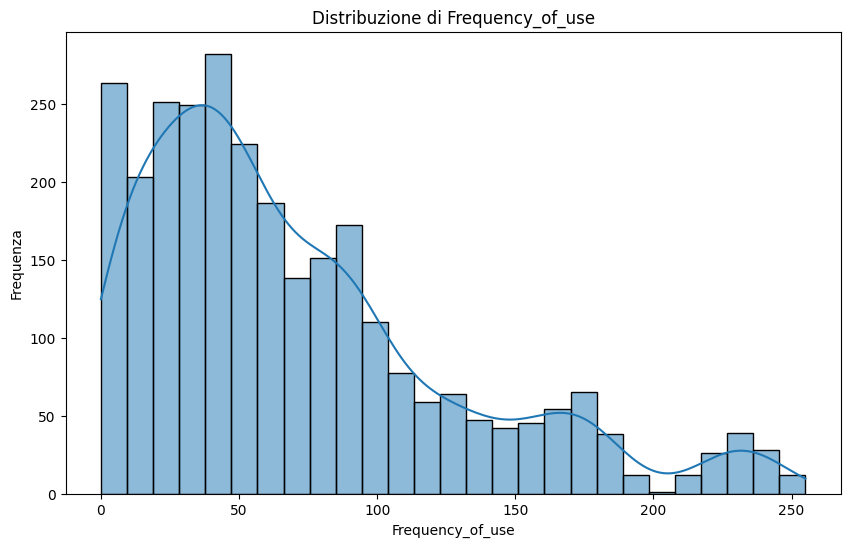

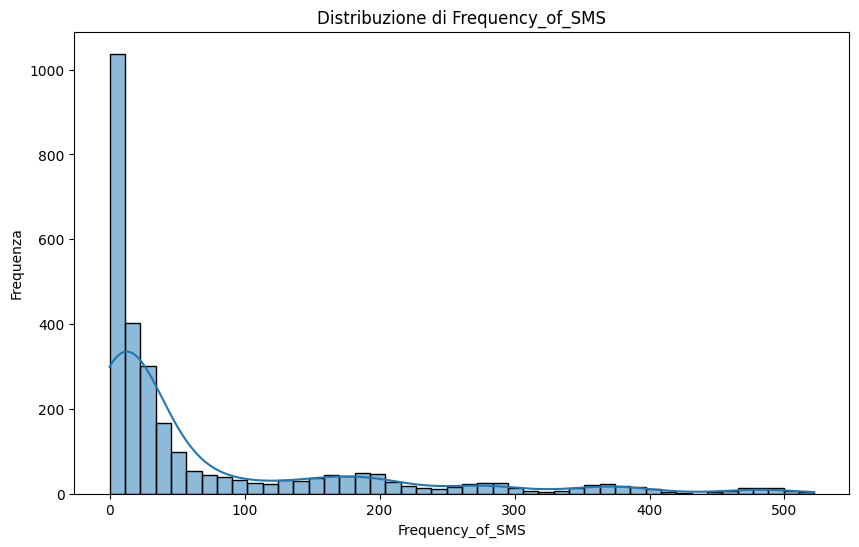

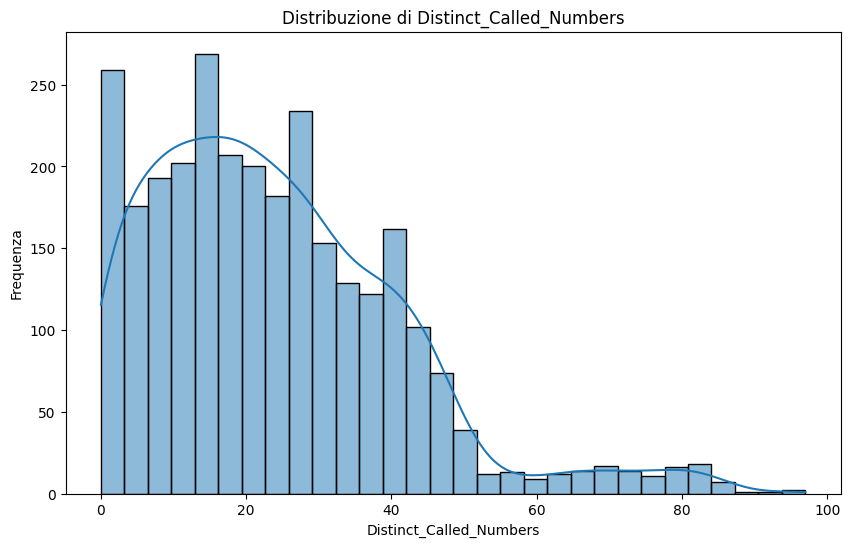

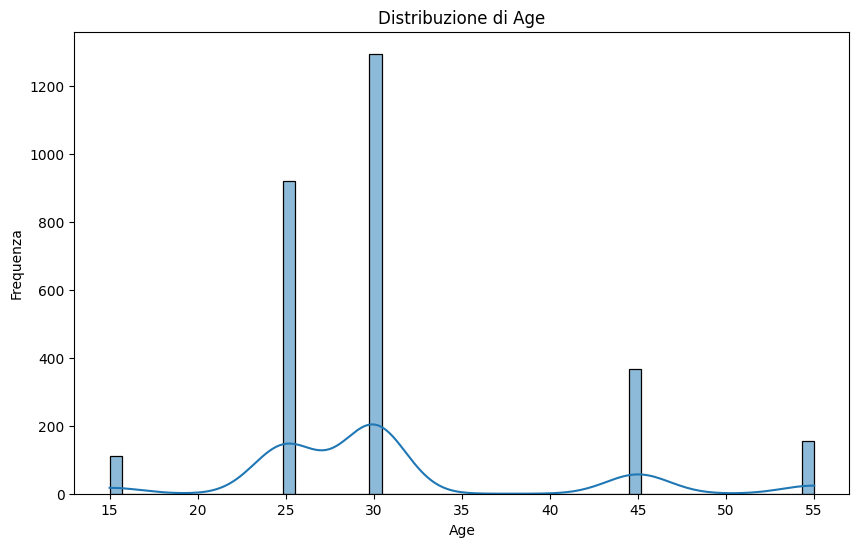

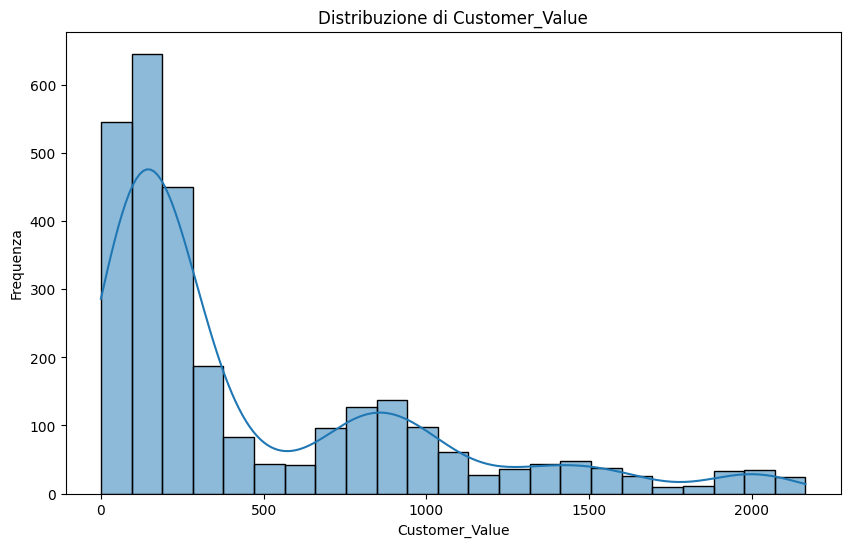

In [52]:
# 1. Visualizzazione delle Distribuzioni

# Variabili numeriche
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribuzione di {col}')
    plt.xlabel(col)
    plt.ylabel('Frequenza')
    plt.show()

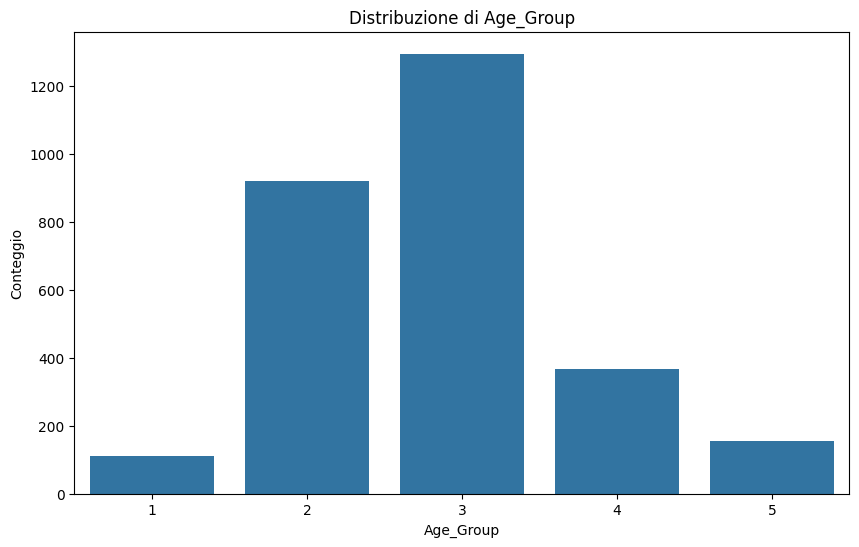

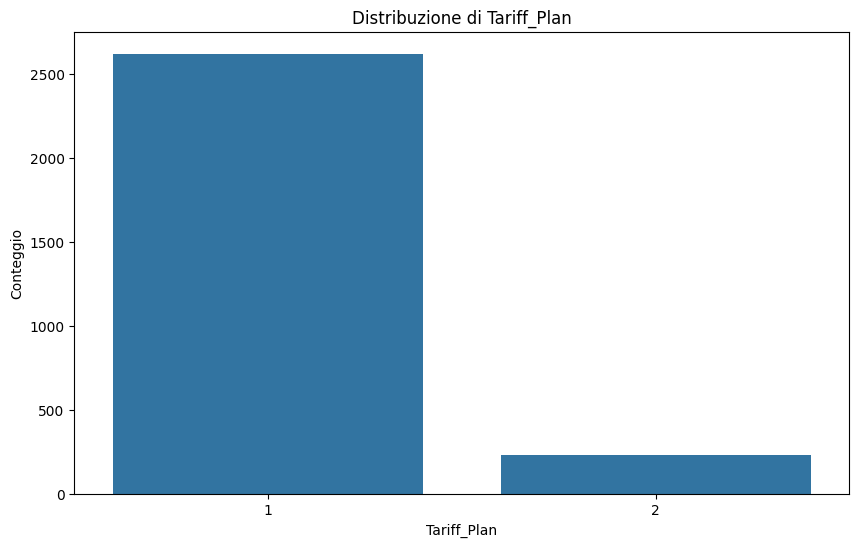

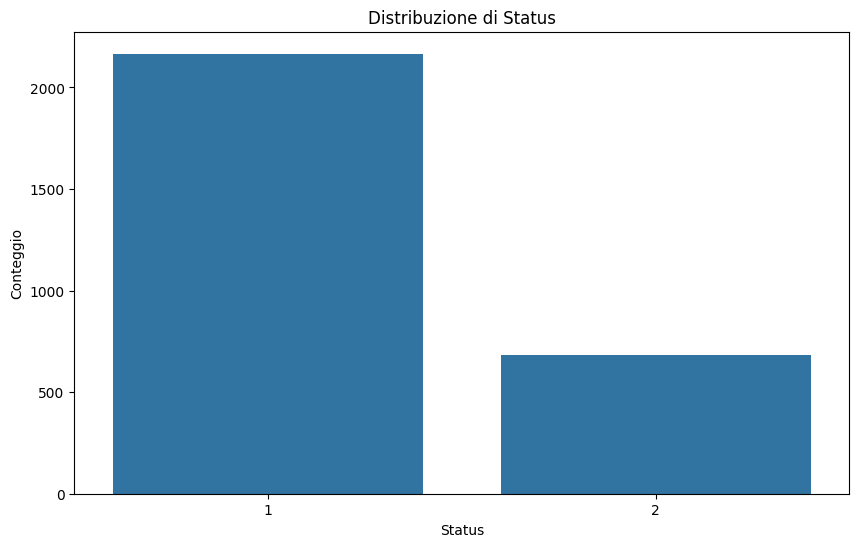

In [53]:
# Variabili categoriche
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=data[col])
    plt.title(f'Distribuzione di {col}')
    plt.xlabel(col)
    plt.ylabel('Conteggio')
    plt.show()

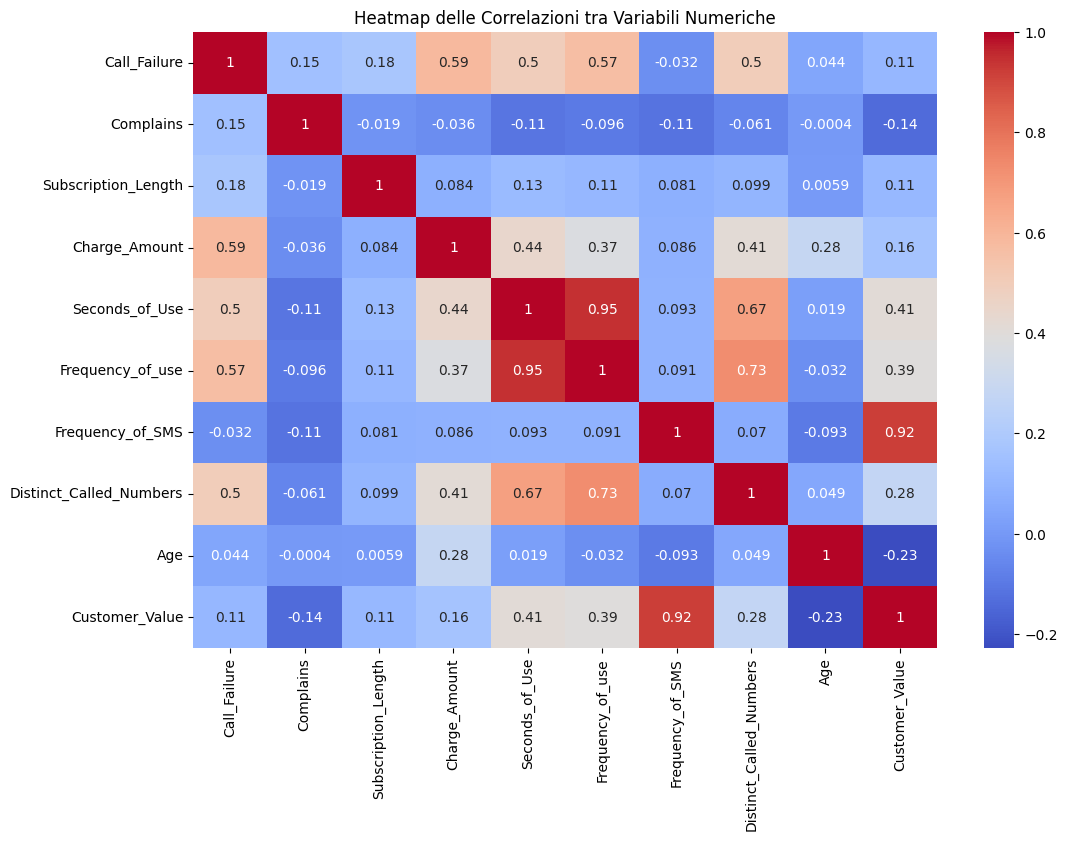

In [54]:
# 2. Analisi delle Correlazioni

plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap delle Correlazioni tra Variabili Numeriche')
plt.show()

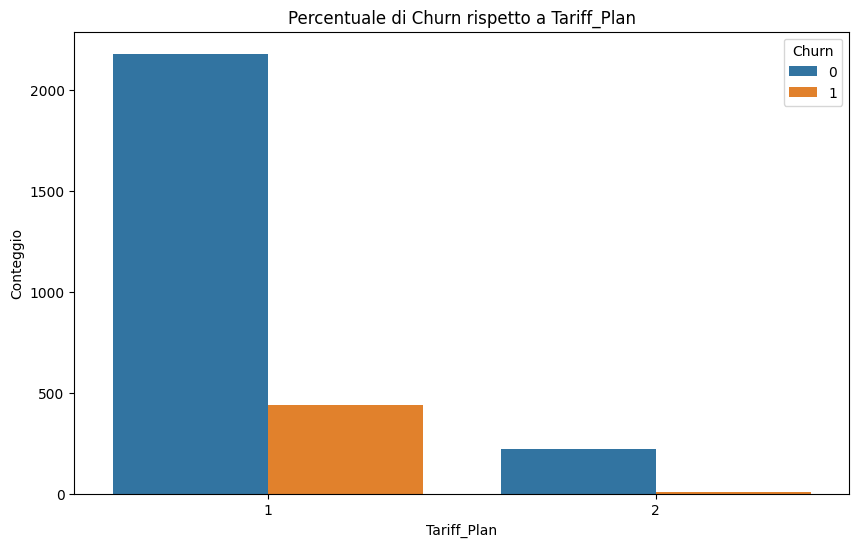

In [55]:

# Percentuale di churn rispetto a Tariff_Plan
plt.figure(figsize=(10, 6))
sns.countplot(x='Tariff_Plan', hue='Churn', data=data)
plt.title('Percentuale di Churn rispetto a Tariff_Plan')
plt.xlabel('Tariff_Plan')
plt.ylabel('Conteggio')
plt.show()

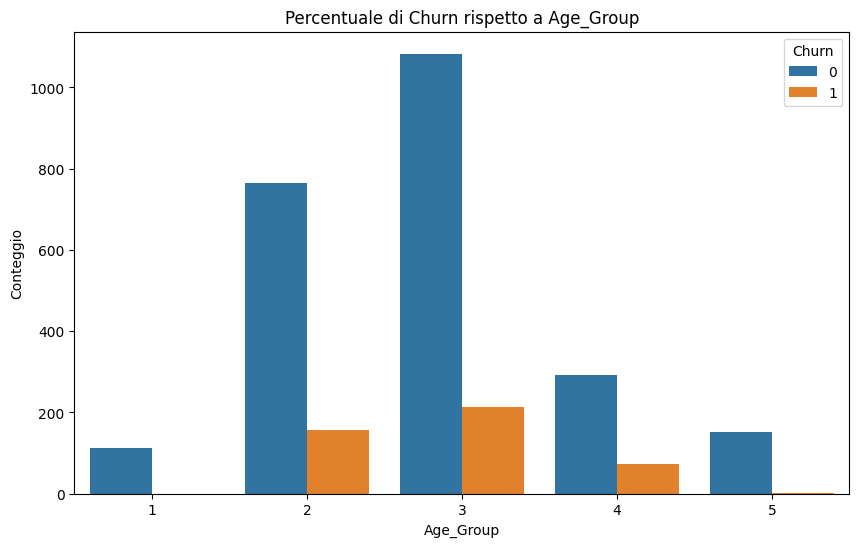

In [56]:

# Percentuale di churn rispetto a Age_Group
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Group', hue='Churn', data=data)
plt.title('Percentuale di Churn rispetto a Age_Group')
plt.xlabel('Age_Group')
plt.ylabel('Conteggio')
plt.show()


### **4. Analysis**
#### **4.1 Random Forest**
The ensemble learning capability of Random Forests (RFs) was used to build **multiple decision trees** and aggregate predictions from these to boost model **accuracy and robustness**, making them suitable for a wide range of tasks. Each tree is built using a different **bootstrap** sample of the data, and at each split in the tree, a random subset of features is selected from which the best feature is chosen to make the split, introducing randomness and so **reducing the risk of overfitting and improve generalization**. The final prediction of the Random Forest is obtained by averaging the predictions of all the individual trees (for regression tasks) or by taking the majority vote (for classification tasks) (Aria et al., 2021).

In [74]:
### Analisi

# Setto la Random Forest
rf_model = RandomForestClassifier(random_state=3)

# Griglia dei parametri per Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setto GridSearchCV per Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# GridSearch per Random Forest
grid_search_rf.fit(X_train_preprocessed, y_train)

# Migliori parametri e punteggi per Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Traino il modello finale di Random Forest con i migliori parametri sull'intero training set
best_rf_model = RandomForestClassifier(**best_params_rf)
best_rf_model.fit(X_train_preprocessed, y_train)

# Previsioni sul training set
final_predictions_rf = best_rf_model.predict(X_test_preprocessed)

# Valutazione del modello finale
final_accuracy = accuracy_score(y_test, final_predictions_rf)
final_classification_report = classification_report(y_test, final_predictions_rf, output_dict=True)

# Risultati
grid_search_results = {
    "Best Random Forest Parameters": best_params_rf,
    "Best Random Forest CV Accuracy": best_score_rf,
    "Final Model Test Accuracy": final_accuracy,
    "Final Model Classification Report": final_classification_report
}
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions_rf))
grid_search_results

Confusion Matrix:
 [[714  13]
 [ 28 100]]


{'Best Random Forest Parameters': {'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 'Best Random Forest CV Accuracy': 0.9619047619047618,
 'Final Model Test Accuracy': 0.952046783625731,
 'Final Model Classification Report': {'0': {'precision': 0.9622641509433962,
   'recall': 0.9821182943603851,
   'f1-score': 0.9720898570456092,
   'support': 727.0},
  '1': {'precision': 0.8849557522123894,
   'recall': 0.78125,
   'f1-score': 0.8298755186721992,
   'support': 128.0},
  'accuracy': 0.952046783625731,
  'macro avg': {'precision': 0.9236099515778928,
   'recall': 0.8816841471801926,
   'f1-score': 0.9009826878589042,
   'support': 855.0},
  'weighted avg': {'precision': 0.9506904959286958,
   'recall': 0.952046783625731,
   'f1-score': 0.9507992894294729,
   'support': 855.0}}}

The best model based on Random Forest has the following parameters and metrics:
* **max_depth: None**, so the trees can grow as deep as possible, potentially creating very complex models that capture a lot of detail from the training data, with overfitting risk but here this problem is somewhat mitigated because multiple trees are averaged.
* **min_samples_leaf: 1**, so a leaf node can be created even if it contains only one sample.
* **min_samples_split: 2**, so any node with at least two samples can be split into child nodes. As min_samples_leaf, a lower value of this hyperparameter makes the trees highly detailed, potentially capturing fine distinctions in data.
* **n_estimators: 200**, it’s the number of individual decision trees in the Random Forest.


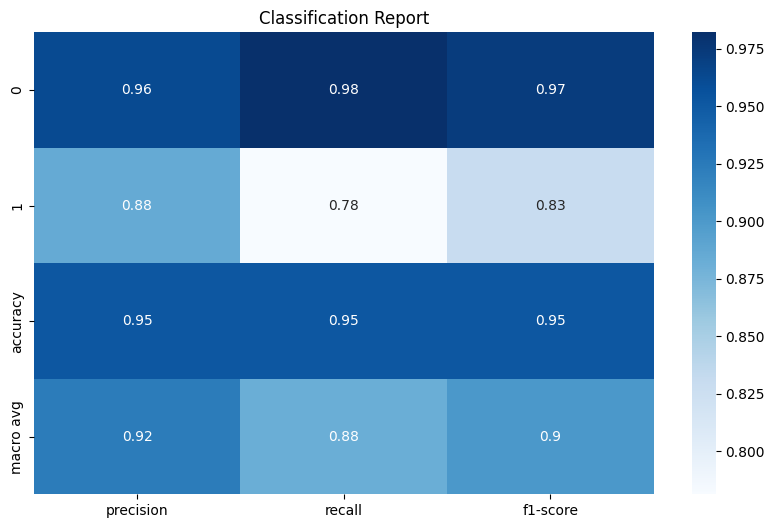

In [76]:
report_rf = pd.DataFrame(final_classification_report).transpose()

# Plotting the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_rf.iloc[:-1, :-1], annot=True, cmap="Blues", cbar=True) 
plt.title('Classification Report')
plt.show()


We can see, through the Classification Report, metrics such as:
* **Precision**: High precision for non-churned customers, indicating that the model is very 
effective in minimizing false positives.
* **Recall**: The recall for churned customers is lower, suggesting some room for improvement in identifying all churned customers.
* **F1-Score**: The F1-score balances precision and recall, providing an overall measure of the model's performance.

Random forests can evaluate the **importance of each feature** in predicting the target variable. This is often done by calculating the decrease in **model accuracy** or **Gini impurity** when a specific feature is excluded from the model (Aria et al., 2021). Main features were identified as most influential in predicting customer churn and showed:

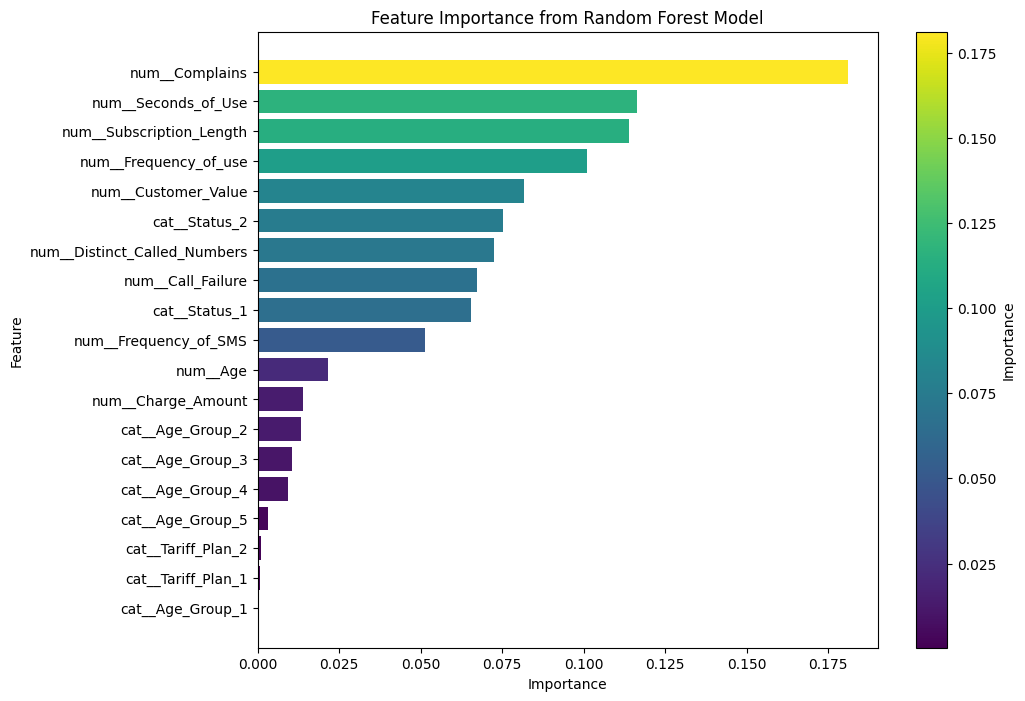

,Feature,Importance
1,num__Complains,0.181125
4,num__Seconds_of_Use,0.116467
2,num__Subscription_Length,0.113830
5,num__Frequency_of_use,0.101030
9,num__Customer_Value,0.081627
18,cat__Status_2,0.075330
7,num__Distinct_Called_Numbers,0.072345
0,num__Call_Failure,0.067431
17,cat__Status_1,0.065292
6,num__Frequency_of_SMS,0.051432


In [58]:
# Valuto importanza variabili per Random Forest
feature_importances = best_rf_model.feature_importances_

# Prendo i nomi delle variabili
feature_names = preprocessor.get_feature_names_out()

# Dataframe sulla base della importanza delle variabili
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Normalizing the importance values for color mapping
norm = plt.Normalize(feature_importance_df['Importance'].min(), feature_importance_df['Importance'].max())
cmap = cm.viridis  # You can choose other colormaps like 'plasma', 'inferno', etc.
colors = cmap(norm(feature_importance_df['Importance']))

# Create a mappable object for colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # We can pass an empty array here

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance from Random Forest Model')
ax.invert_yaxis()

# Adding the colorbar next to the plot
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Importance')

plt.show()

# Display the dataframe
feature_importance_df


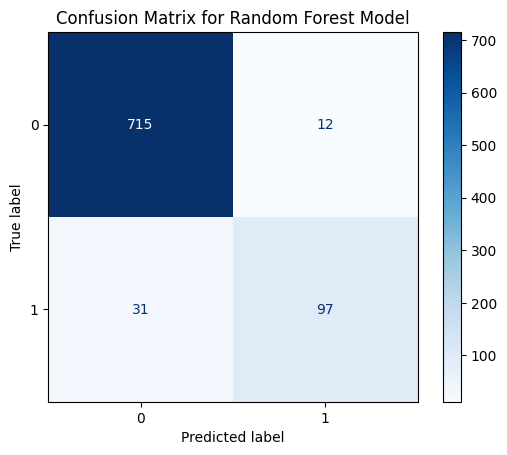

In [64]:
# Compute confusion matrix
cm = confusion_matrix(y_test, final_predictions_rf)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


#### **4.2 Artificial Neural Network (ANN)**

Artificial Neural Networks, more commonly referred to as ANNs, are a class of **computational models** that take root from the **structure and function of the human brain**. The concept of ANNs relates to the semblance of biological neurons in the brain in terms of information processing. It consists of **layers of interconnected "neurons" or nodes** which try to solve complex computational problems collectively, with special emphasis on pattern recognition and tasks requiring classification *(McCulloch & Pitts, 1943; Rosenblatt, 1958)*.

In [79]:
# Trasformo la Y in intero così da poterla utilizzare nella ANN
y_ann = data['Churn'].astype('int')

y_train_ann, y_test_ann = train_test_split(y_ann, test_size=0.3, random_state=3)

# Standardizzazione delle caratteristiche
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Funzione per la NN
def create_nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Addestro il modello
nn_model = create_nn_model()
history = nn_model.fit(X_train_scaled, y_train_ann, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Valutazione ANN
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")

ann_report = classification_report(y_test_ann, y_pred_nn, output_dict=True)

print("Neural Network Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test_ann, y_pred_nn))
print("Classification Report:\n", ann_report)

Epoch 1/100


c:\Users\Gabriele\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7814 - loss: 0.5465 - val_accuracy: 0.8521 - val_loss: 0.3746
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3710 - val_accuracy: 0.8822 - val_loss: 0.2857
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.3412 - val_accuracy: 0.9023 - val_loss: 0.2645
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3052 - val_accuracy: 0.9173 - val_loss: 0.2507
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.2904 - val_accuracy: 0.9023 - val_loss: 0.2434
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8783 - loss: 0.2757 - val_accuracy: 0.8972 - val_loss: 0.2325
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 - loss: 0.2679 - val_accuracy: 0.8947 - val_loss: 0.2278
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.2730 - val_accuracy: 0.8997 - val_loss: 0.2

The ANN began training at an accuracy of 78.14%, quickly rising, to finish at 96.14% by the 100th epoch. This, too, does not show a very steady decrease across epochs but rather a bit varied one, so it shows good learning. The final validation loss is 0.1307, which means the model can discern quite well the underpinnings of data.

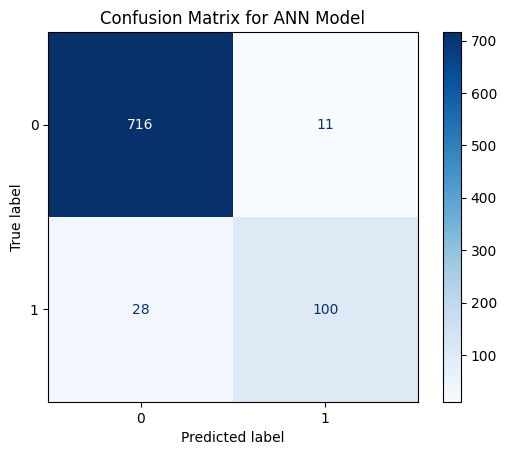

In [80]:
# Compute confusion matrix
cm = confusion_matrix(y_test_ann, y_pred_nn)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for ANN Model')
plt.show()


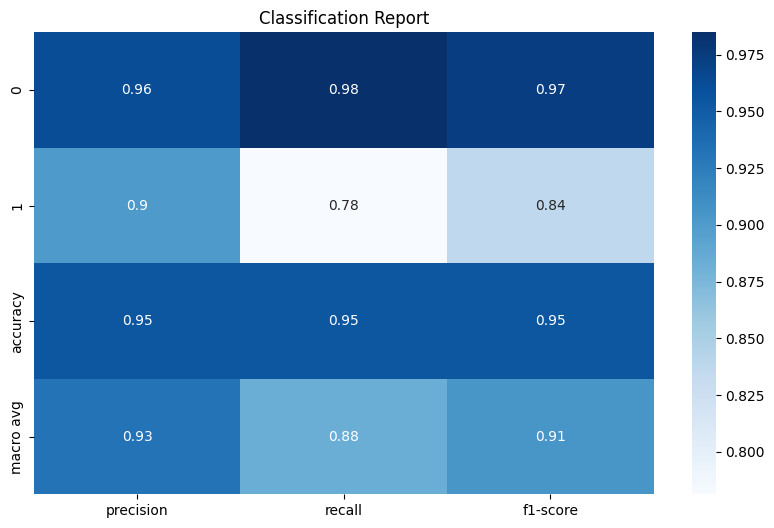

In [81]:
report_ann = pd.DataFrame(ann_report).transpose()

# Plotting the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_ann.iloc[:-1, :-1], annot=True, cmap="Blues", cbar=True) 
plt.title('Classification Report')
plt.show()

In [44]:
#Per visualizzare la ANN
#nn_model.save('model.h5')

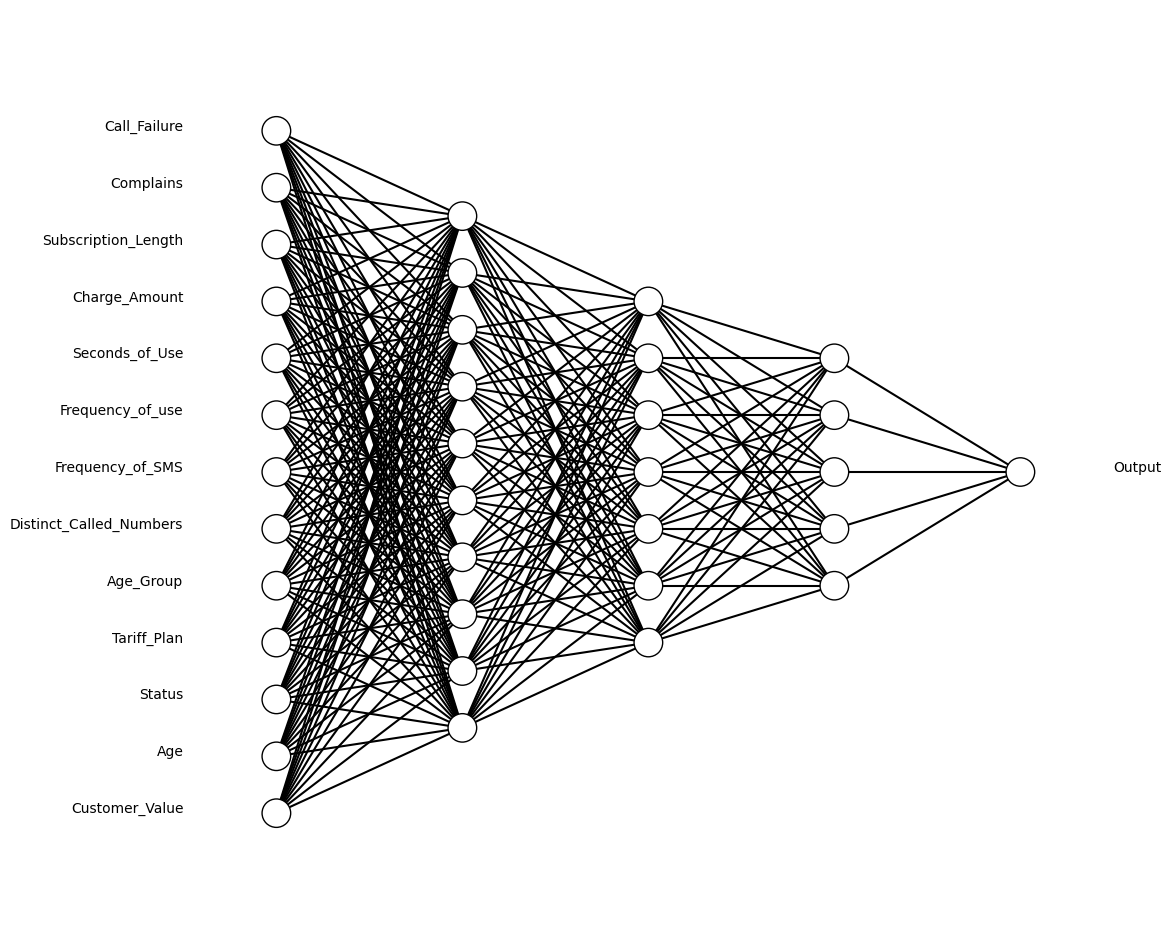

In [47]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, input_labels=None):
    '''
    Draw a neural network cartoon using matplotlib.
    
    Arguments
    ---------
    ax : matplotlib.axes.AxesSubplot : The axes on which to plot the cartoon (get e.g. by plt.gca())
    left : float : The center of the leftmost node(s) will be placed here
    right : float : The center of the rightmost node(s) will be placed here
    bottom : float : The center of the bottommost node(s) will be placed here
    top : float : The center of the topmost node(s) will be placed here
    layer_sizes : list : List containing the number of nodes in each layer
    input_labels : list : List of labels for the input nodes (default is None)
    '''
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if n == 0 and input_labels:
                ax.text(left - 0.1, layer_top - m*v_spacing, input_labels[m], horizontalalignment='right')
            if n == len(layer_sizes) - 1:
                ax.text(right + 0.1, layer_top - m*v_spacing, f"Output", horizontalalignment='left')
    
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Feature names from the dataset
feature_names = list(data.columns.drop('Churn'))

# Parameters for drawing
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [13, 10, 7, 5, 1], input_labels=feature_names)
plt.show()


#### **4.3 Stacking Ensemble**

The Stacked Ensemble model is an advanced variety of machine learning in which, considering a certain dataset, more than one base model is usually trained, also referred to as Level-0 models. The predictions made through such **base learners** result in another model known as the meta-learner or Level-1 model. A **meta-learner** aims at learning how to combine predictions made by base models in order to arrive at a final, more accurate prediction.
I used it in work where base learners were **Logistic Regression** and **Gradient Boosting**, and a **Random Forest** was applied as a meta-learner *01(Ali et al., 2022)*. It allows the model to learn from good properties both of linear and nonlinear models, thus making it give better precision and robust predictions compared with any one model.

In [77]:

# Setto per Stacking Ensemble, composta da Regressione Logistica, Boosting e come meta modello la RF
base_classifiers = [
    ('lr', LogisticRegression(max_iter=100, random_state=3)),
    ('gb', GradientBoostingClassifier(random_state=3))
]

meta_model = RandomForestClassifier(random_state=3)

stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])

pipeline.fit(X_train, y_train)

# Previsione
y_pred = pipeline.predict(X_test)

stacked_classification_report = classification_report(y_test, y_pred, output_dict=True)

# Valutazione Stacking Ensemble
print("Stacking Ensemble Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", stacked_classification_report)

Stacking Ensemble Performance:
Confusion Matrix:
 [[709  18]
 [ 29  99]]
Classification Report:
 {'0': {'precision': 0.9607046070460704, 'recall': 0.9752407152682255, 'f1-score': 0.9679180887372013, 'support': 727.0}, '1': {'precision': 0.8461538461538461, 'recall': 0.7734375, 'f1-score': 0.8081632653061225, 'support': 128.0}, 'accuracy': 0.9450292397660819, 'macro avg': {'precision': 0.9034292265999583, 'recall': 0.8743391076341127, 'f1-score': 0.8880406770216619, 'support': 855.0}, 'weighted avg': {'precision': 0.9435554872867665, 'recall': 0.9450292397660819, 'f1-score': 0.9440015771592153, 'support': 855.0}}


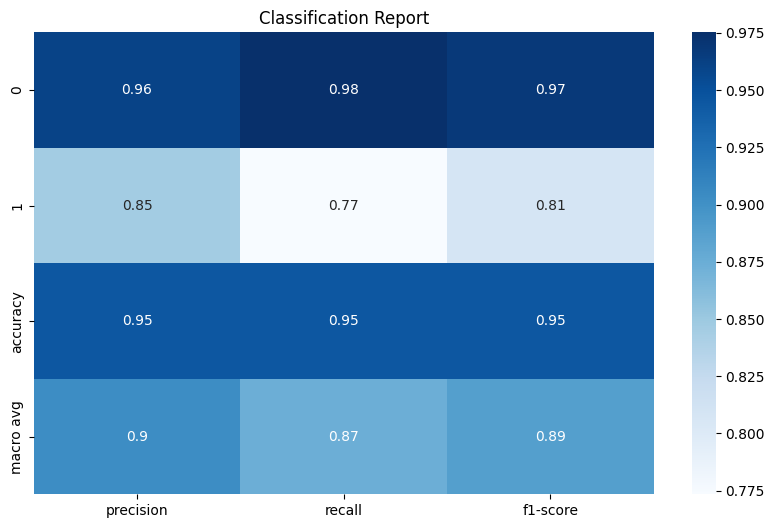

In [78]:
report_se = pd.DataFrame(stacked_classification_report).transpose()

# Plotting the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_se.iloc[:-1, :-1], annot=True, cmap="Blues", cbar=True) 
plt.title('Classification Report')
plt.show()


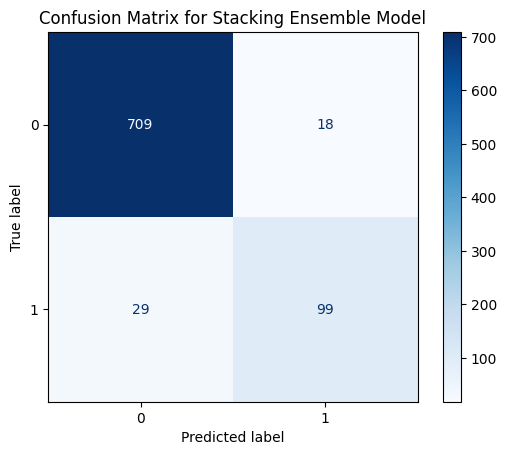

In [69]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Stacking Ensemble Model')
plt.show()
